Ce programme est pour but de résoudre la GPE: 
    $$
i\frac{\partial}{\partial t} \varphi(x ; y ; t)= \left[-\frac{\partial^2}{\partial x^2}+\frac{x^2}{4}+k\frac{y^2}{4}+\mathcal{N}|\varphi(x ; y ; t)|^2\right] \varphi(x ; y; t) \equiv H \varphi(x ; y ; t)
$$

Pour tester le programme et implémenter la méthode de temps réel et de temps imaginaire, on ajoute deux paramètres w et R et résoudre numériquement équation:
   $$
 \frac{\partial}{\partial t} \varphi(x ; y ; t)= R \left[-\frac{\partial^2}{\partial x^2}+w\frac{x^2}{4}+k\frac{y^2}{4}+\mathcal{N}|\varphi(x ; y ; t)|^2\right] \varphi(x ; y ; t) \equiv H \varphi(x ; y ; t)
$$
w est un nombre réelle, R = -$\mathrm{i}$ : méthode de temps réel; R = -1 méthode de temps imaginaire

Ici on utilise la méthode "Split-step", c'est à dire on sépare H en deux parties $H = H_{1} + H_{2}$
$$
H_{1} = R \left[w\frac{x^2}{4}+k\frac{y^2}{4}+\mathcal{N}|\varphi(x ; t)|^2\right]
\\
H_{2} = R \left[-\frac{\partial^2}{\partial x^2}\right]
$$
On résout $\frac{\partial}{\partial t} \varphi(x ; y ; t)= H_{1}\varphi(x ; y ; t)$ en gardant $H_{1} $ est une constante et puis $\frac{\partial}{\partial t} \varphi(x ; y ; t)= H_{2}\varphi(x ; y ; t)$ par la méthode de spectrale

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

class GPE1D:
    """A class that solves  du/dt = R* [- d^2(u)/(dt)^2 + [w*x^2/4 + k*y^2/4 + N.u^2]*u]
    Spectral stepping method for solving PDEs"""
    def __init__(self, Nx, Ny, Lx, Ly, w, k, N, r = 1): 
        """Initialize the spatial and spectral grids
        If r = 1: method real time, if r = 0: method imaginary time"""
        self.Nx,self.Ny,self.Lx,self.Ly = Nx,Ny,Lx,Ly
        self.w,self.k,self.N = w,k,N
        self.x, self.dx = np.linspace(-self.Lx, self.Lx, self.Nx, retstep=True)      
        self.y, self.dy = np.linspace(-self.Ly, self.Ly, self.Ny, retstep=True)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.kx = 2*np.pi*np.fft.fftfreq(self.Nx, d=self.dx)   
        self.ky = 2*np.pi*np.fft.fftfreq(self.Ny, d=self.dy)  
        self.Kx, self.Ky = np.meshgrid(self.kx, self.ky)

        if r == 0:
            self.R = -1
            self.u = np.zeros((Nx,Ny),dtype = float)
        else:   
            self.R = -1j
            self.u = np.zeros((Nx,Ny),dtype = complex)

        
    def initialize(self, func):
        """Set the initial condition"""
        self.u = func(self.X,self.Y)
        
    def FourierStep(self, dt):
        """Make a step dt forward in time for du/dt = -R*d^2(u)/dt^2"""
        uk = np.fft.fft2(self.u)
        uk = np.exp((self.Kx**2+self.Ky**2) * dt*self.R)*uk
        if self.R == -1j:
            self.u = np.fft.ifft2(uk)
        else:
            self.u = np.fft.ifft2(uk).real

    def step(self,dt):
        """Make a step dt forward in time for i*du/dt = H.u"""
        self.FourierStep(dt)
        self.H1Step(dt)
        
    def H1Step(self,dt): 
        """Make a step dt forward in time for i*du/dt = (w*x^2/4 + k*y^2/4 + N.u^2)*u"""
        self.u = self.u * np.exp(self.R*(self.w*self.X**2/4+self.k*self.Y**2/4 + self.N * abs(self.u)**2) * dt)
        
'''        
    def H1Step(self,dt):  #methode runga kutta ordre 4
        """Make a step dt forward in time for du/dt = R*[w*x^2/4 + N.u^2]*u"""
        
        if self.R == -1j:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = complex)
        else:
            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = float)
            
        N,w,R,x,u = self.N,self.w,self.R,self.x,self.u
        k1 = R*(w*x**2/4 + N * abs(u)**2)*dt* u
        k2 = R*(w*x**2/4 + N * abs(u+k1/2)**2)*dt* (u+k1/2)
        k3 = R*(w*x**2/4 + N * abs(u+k2/2)**2)*dt* (u+k2/2)
        k4 = R*(w*x**2/4 + N * abs(u+k3)**2)*dt* (u+k3)
        self.u += k1/6 + k2/3 + k3/3 + k4/6 
'''

'        \n    def H1Step(self,dt):  #methode runga kutta ordre 4\n        """Make a step dt forward in time for du/dt = R*[w*x^2/4 + N.u^2]*u"""\n        \n        if self.R == -1j:\n            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = complex)\n        else:\n            k1,k2,k3,k4 = np.zeros((4,self.Nx),dtype = float)\n            \n        N,w,R,x,u = self.N,self.w,self.R,self.x,self.u\n        k1 = R*(w*x**2/4 + N * abs(u)**2)*dt* u\n        k2 = R*(w*x**2/4 + N * abs(u+k1/2)**2)*dt* (u+k1/2)\n        k3 = R*(w*x**2/4 + N * abs(u+k2/2)**2)*dt* (u+k2/2)\n        k4 = R*(w*x**2/4 + N * abs(u+k3)**2)*dt* (u+k3)\n        self.u += k1/6 + k2/3 + k3/3 + k4/6 \n'

In [3]:
def advance(GPE, dt, Nt): #Advance GPE Nt pas d'intervalle dt
    for _ in range(Nt):
        GPE.step(dt)

In [4]:
class Gaussian:
    """Gaussian function f(x) = amplitude * exp{-(x-x0)^2/widthx^2 - (y-y0)^2/widthy^2}"""
    def __init__(self, amplitude, widthx, widthy, x0, y0):
        """Create Gaussian with the given width and amplitude, centered at x = x0"""
        self.amp, self.widthx, self.widthy = amplitude, widthx, widthy
        self.x0, self.y0 = x0,y0
        
    def __call__(self, x,y):
        """Evaluate the function for the values of x"""
        return self.amp * np.exp(-(x-self.x0)**2 / self.widthx**2 -(y-self.y0)**2/self.widthy**2)
    
# create a Gaussian object
gauss = Gaussian(50,0.532,0.532,0,0) 

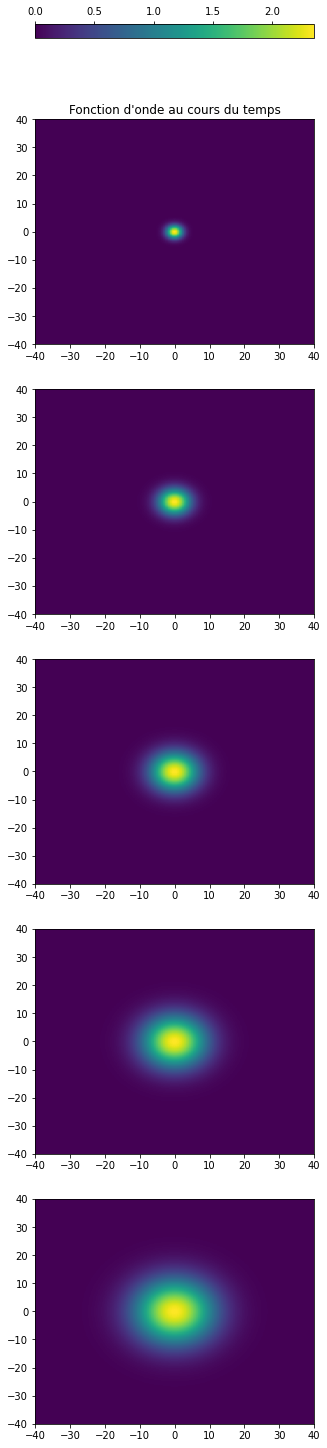

In [5]:
#Test for w = 0, N = 0, R = 0: étalement d'onde gaussienne
w = 0           # Valeur de w dans l'equation
k = 0              #Valeur de k dans l'equation
N = 0        # Valeur de N dans l'equation
Nx = Ny = 400      # Nombre de pas de x
Lx = Ly = 40        # x_max; dx = L/Nx
Nt = 100      # Nombre de pas de temps
dt = 0.003         # Intervalle de temp; T = Nt * dt
NT = 5       #Nombre de pas de T
GPE = GPE1D(Nx, Ny, Lx, Ly, w, k, N, r = 1)
GPE.initialize(gauss)

#Graphiques au cours du temps
X = GPE.X
Y = GPE.Y
fig, ax = plt.subplots(NT,figsize=(5,6*NT))
for i in range(NT):
    advance(GPE,dt,Nt)
    im = ax[i].pcolormesh(X, Y, abs(GPE.u))
fig.colorbar(im, ax = ax[:], location = 'top',shrink = 1)
ax[0].set_title("Fonction d'onde au cours du temps")
plt.show()
